<a href="https://colab.research.google.com/github/Remato/cat-species-classifier/blob/main/catClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Fastai usage
#### Group:

Renato Barboza da Costa - rbc4

Description: My project is about a model which classifies different types of cats (persian cat, siamese cat, egyptian cat, munchikin cat, russian cat, sphynx cat, turkish cat) and provides the user with the odds of being each of the given types

In [ ]:
#Added to fix error "ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you’ll have torch 1.7.1 which is incompatible."

###########
!pip install torchtext==0.8.1
!pip install -U fastbook
###########

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Requirement already up-to-date: fastbook in /usr/local/lib/python3.7/dist-packages (0.0.16)


## Importing all necessary libraries

**This cell have all imports for the code to be more organized and the next cells will be dedicated exclusively to training, development and other functions.**

In [ ]:
from fastbook import *
from fastai.vision.widgets import *
import os
from bs4 import BeautifulSoup
import re
import urllib.request
import os

### [1] Getting all need data from web using a "simple crawler"

In [ ]:
def get_images_from_web(queries):
    for query in queries:
        name = query.lower()
        name = name.split()
        if len(name) == 3:
          name = name[0] + " " + name[1]
        else:
          name = name[0]
        query = query + " images"
        query = query.split(" ")
        query = '+'.join(query)
        url = "https://www.google.co.in/search?q="+query+"&source=lnms&tbm=isch"
        print(url)

        DIR = "dataset"
        header={'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64; Trident/7.0; rv:11.0) like Gecko'}
        soup = BeautifulSoup(urllib.request.urlopen(urllib.request.Request(url,headers=header)),'html.parser')


        frontierImages = [] 
        for a in soup.find_all("img", {"class": "rg_i"}):
          link = a.get('data-src')

          if link != None:
            frontierImages.append(link)
          if len(frontierImages) == 80:
            break
            
        print("There are total", len(frontierImages),"images")

        if not os.path.exists(DIR):
          os.mkdir(DIR)

        DIR = os.path.join(DIR, name.split()[0])

        if not os.path.exists(DIR):
          os.mkdir(DIR)

        for i , img in enumerate(frontierImages):
          try:
            req = urllib.request.Request(img)
            raw_img = urllib.request.urlopen(req).read()

            cntr = len([i for i in os.listdir(DIR) if name in i]) + 1
            f = open(os.path.join(DIR , name + "_"+ str(cntr)+".jpg"), 'wb')

            f.write(raw_img)
            f.close()
          except Exception as e:
            print("could not load : " + img)
            print(e)

### [2] Defining our queries to collect the data

In [ ]:
queries = ["siamese cat", "munchikin cat", "sphynx cat", "turkish van", "bengal cat", "bombay cat" , "foldex cat", "york chocolate cat", "maine coon"]
get_images_from_web(queries)

https://www.google.co.in/search?q=siamese+cat+images&source=lnms&tbm=isch
There are total 80 images
https://www.google.co.in/search?q=munchikin+cat+images&source=lnms&tbm=isch
There are total 80 images
https://www.google.co.in/search?q=sphynx+cat+images&source=lnms&tbm=isch
There are total 80 images
https://www.google.co.in/search?q=turkish+van+images&source=lnms&tbm=isch
There are total 80 images
https://www.google.co.in/search?q=bengal+cat+images&source=lnms&tbm=isch
There are total 80 images
https://www.google.co.in/search?q=bombay+cat+images&source=lnms&tbm=isch
There are total 80 images
https://www.google.co.in/search?q=foldex+cat+images&source=lnms&tbm=isch
There are total 80 images
https://www.google.co.in/search?q=york+chocolate+cat+images&source=lnms&tbm=isch
There are total 80 images
https://www.google.co.in/search?q=maine+coon+images&source=lnms&tbm=isch
There are total 80 images


### [3] Creating path to my images and create a new dataset with them.

In [ ]:
path = "dataset"
fns = get_image_files(path)
fns

(#1440) [Path('dataset/york/york chocolate_130.jpg'),Path('dataset/york/york chocolate_140.jpg'),Path('dataset/york/york chocolate_151.jpg'),Path('dataset/york/york chocolate_111.jpg'),Path('dataset/york/york chocolate_21.jpg'),Path('dataset/york/york chocolate_69.jpg'),Path('dataset/york/york chocolate_44.jpg'),Path('dataset/york/york chocolate_46.jpg'),Path('dataset/york/york chocolate_87.jpg'),Path('dataset/york/york chocolate_84.jpg')...]

### [4] Filtering corrupted images.

In [ ]:
failed = verify_images(fns)
failed

# ok, we don't have any corrupted images to take from our example (17/04/2021  9:27 PM), so we already have a good database now :)

(#0) []

### [5] Cleaning Data (if needed in the future)

In [ ]:
# verify_images returns an object of type L, which includes the map method.
# This calls the passed function on each element of the collection:

failed.map(Path.unlink);

### [6] Creating DataLoaders with my filtered data

In [ ]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

#### [6.1] Adding my data source to my DataLoader

In [ ]:
dls = cats.dataloaders(path)

#### [6.2] Checking data *samples*

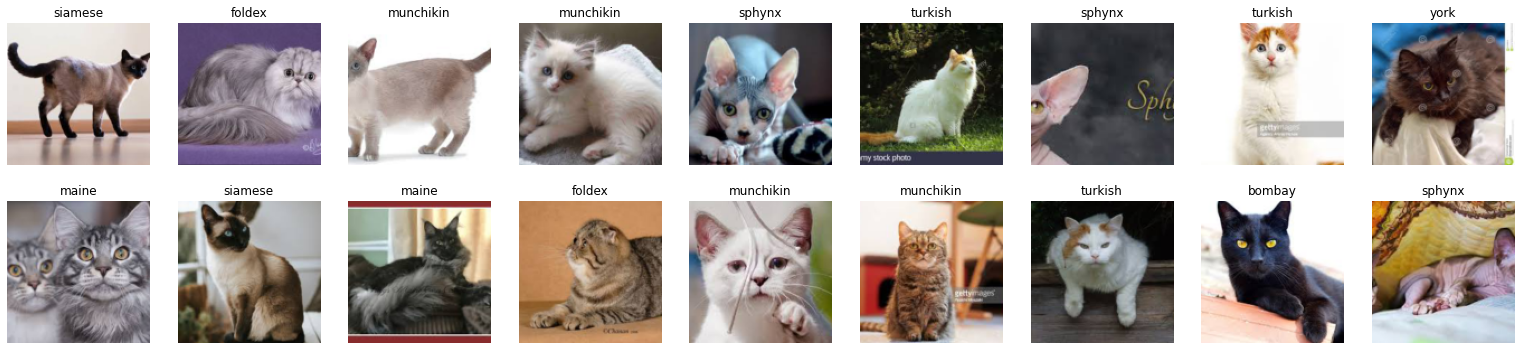

In [ ]:
dls.valid.show_batch(max_n=18, nrows=2)

### [7] Error mitigations (**Squish** | **Pad** | **RandomResizedCrop**)
**In this cell, the AI learns to identify the same images in different patterns, such as:**

  * Squish images;
  * Randomly cropped image;
  * Padding image;

#### [7.1] Applying the squish method

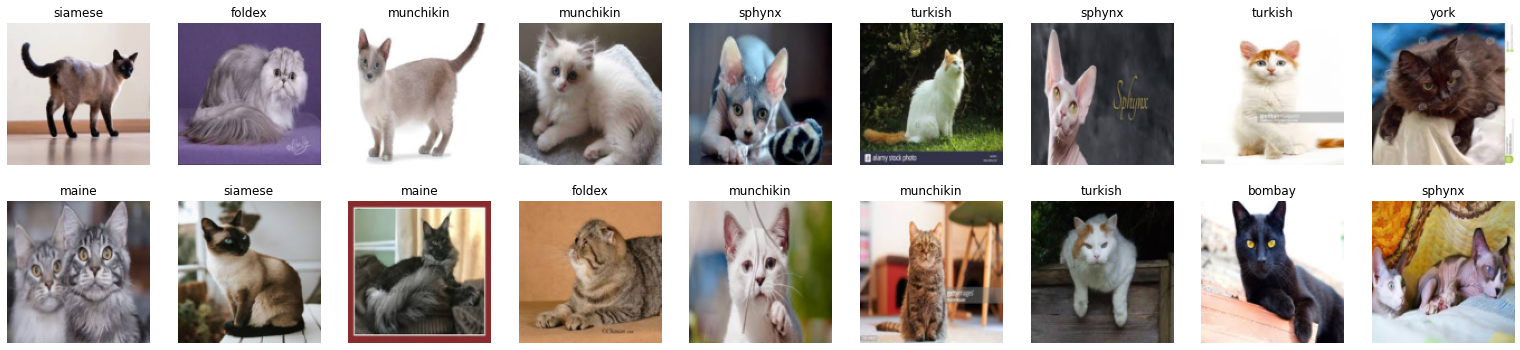

In [ ]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=18, nrows=2)

#### [7.2] Applying padding method

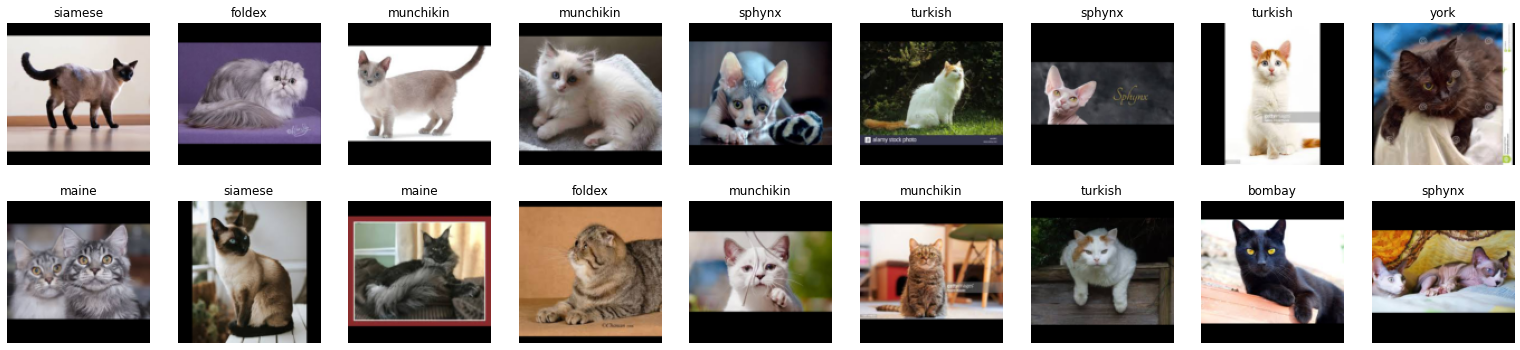

In [ ]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=18, nrows=2)

#### [7.3] Applying random crop method

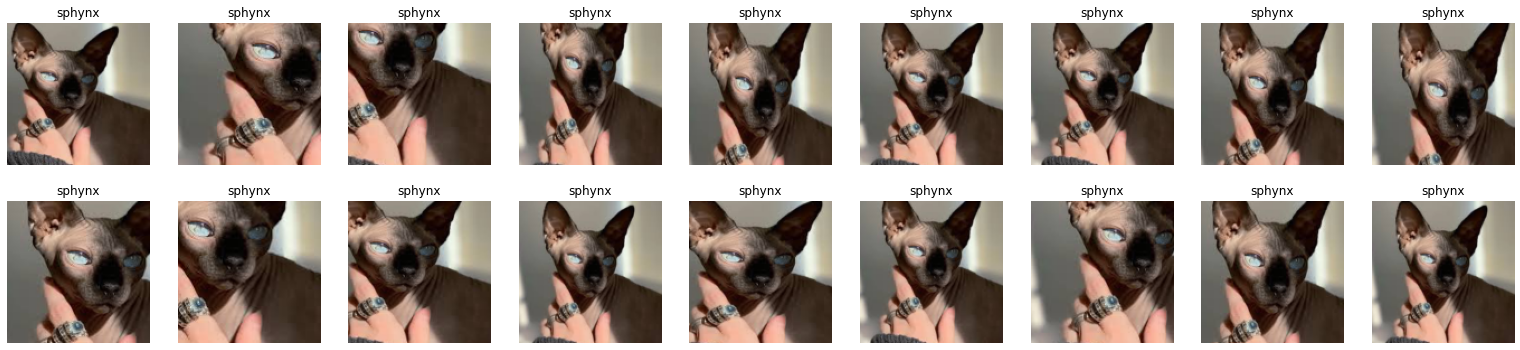

In [ ]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=18, nrows=2, unique=True)

### [8] Now, I'm going to use data augmentation in my dataset applying **aug_transforms**.

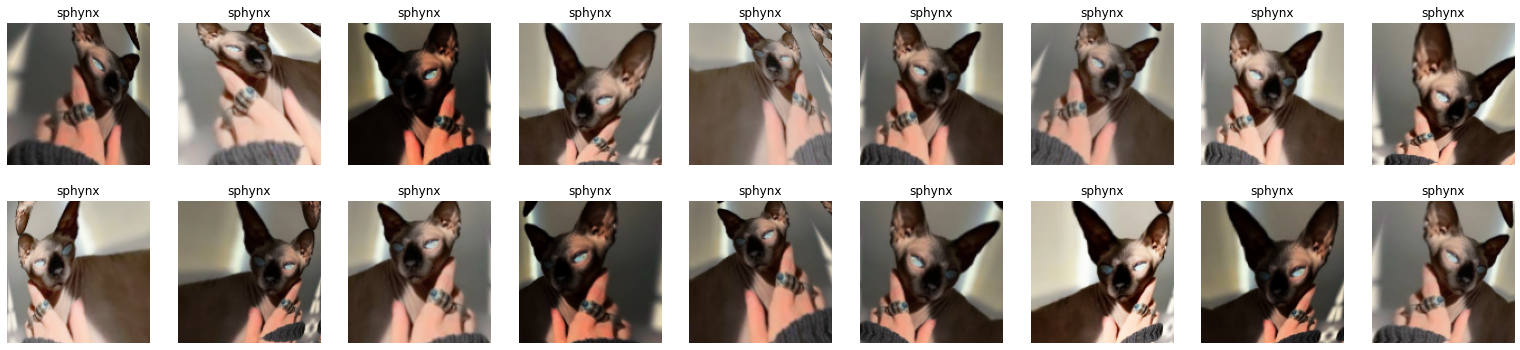

In [ ]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=18, nrows=2, unique=True)

### [9] Improve my DataSet

I'm using  ( **RandomResizedCrop** | **aug_transforms** ) to improve the DataSet training

In [ ]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

dls = cats.dataloaders(path)

### [10] Creating ( **Learner** | **fine_tune** ) and generate the **Loss x Learning Rate** graph
  * Learner: used for group a model, DataLoaders and a loss_func to train.
  * fine_tune: will help to improve the accuracy of a new neural network model
  * Loss: they are used to determine the error(loss) between the output of our algorithms and the target value

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


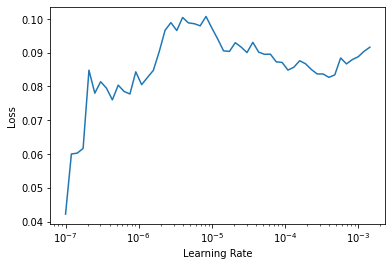

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)
lr_min, lr_steep = learn.lr_find()

In [ ]:
# Min and Max points
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 7.59e-08, steepest point: 9.12e-07


### [11] Error visualization
Now let's visualize the mistakes in a Matrix

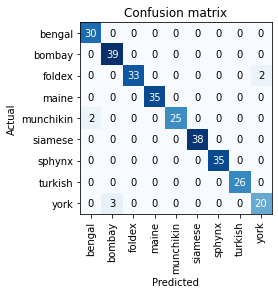

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### [12] Analysing most incorrect predictions with **most_confused** method

In [ ]:
interp.most_confused(min_val=1)

[('york', 'bombay', 3), ('foldex', 'york', 2), ('munchikin', 'bengal', 2)]

### [13] Cleaning data that may be a problem for our model with **ImageClassifierCleaner** method

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

# when outputting clean data, we can see that most images have multiple cats, which makes it difficult to identify a specific specie.

#### [13.1] Removing useless data

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

### [14] Exporting my model

In [ ]:
learn.export(fname='catSpeciePredictor.pkl')

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('catSpeciePredictor.pkl')]

In [ ]:
learn_inf = load_learner(path/'catSpeciePredictor.pkl')

### [15] Application ready for testing

In [ ]:
# upload a cat picture 

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

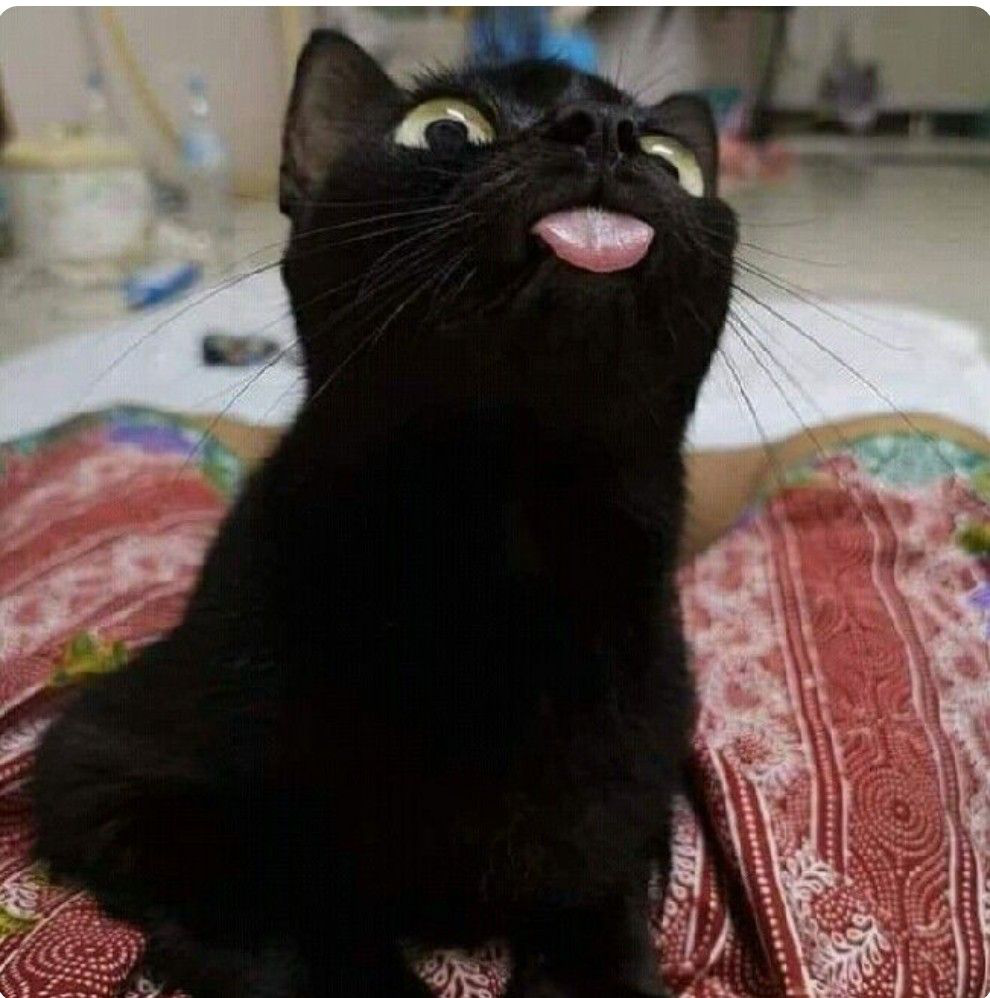

In [ ]:
img = PILImage.create(btn_upload.data[-1])
img

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))

In [ ]:
pred, pred_idx, probs = learn_inf.predict(img)

#### [15.1] Categorization according to my model

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: bombay; Probability: 0.9937')

## Project conclusion

In [ ]:
btn_run = widgets.Button(description='Classify')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred} cat; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

# Final Application
VBox([widgets.Label('Select your cat! :)'), 
      btn_upload, btn_run, out_pl, lbl_pred])